# Jul 5th, 2022 (Fig-3 OCs -- draft)

**Motivation**:  <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from model.configuration import Config
from model.mouse import Mice
from figures.fighelper import *
from analysis.bootstrap import *
from analysis.network import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

## Fig dir

In [2]:
nn = 512
fig_dir = 'Fig3_OCs'
fig_dir = pjoin(fig_base_dir, 'paper2.0', f'n{nn}', fig_dir)
os.makedirs(fig_dir, exist_ok=True)
print(fig_dir)

kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/paper2.0/n512/Fig3_OCs

## Prepare (512)

In [3]:
mice = Mice(nn)
pal, _BOLD, _CAS, _CAF = prepare_palette(0.6)

In [4]:
task = 'rest'

num_k, p = 7, 20
perc = f'p{p}-sample'
props_base = {
    'kw_kmeans': {'n_init': 100},
    'perc': perc,
    'num_k': num_k,
    'mice': mice,
    'task': task,
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bo = {'mode': 'bold-lite', **props_base}

bt = BootStrap(**props_ca)

props_bo['num_k'] += 1
bt_bo = BootStrap(**props_bo)

mice.setup_func_data(task, band_ca=(0.01, 0.5))
bt_cas = BootStrap(**props_ca)

mice.setup_func_data(task, band_ca=0.5)
bt_caf = BootStrap(**props_ca)

bt_dict = {
    _BOLD: bt_bo,
    _CAS: bt_cas,
    _CAF: bt_caf,
}

## OCs

In [5]:
kws_show = {
    'vmin': 0.2,
    'vmax': 1.0,
    'mask_thresh': 1 / num_k,
    'ylabel_fontsize': 20,
    'figsize': (40, 5),
}

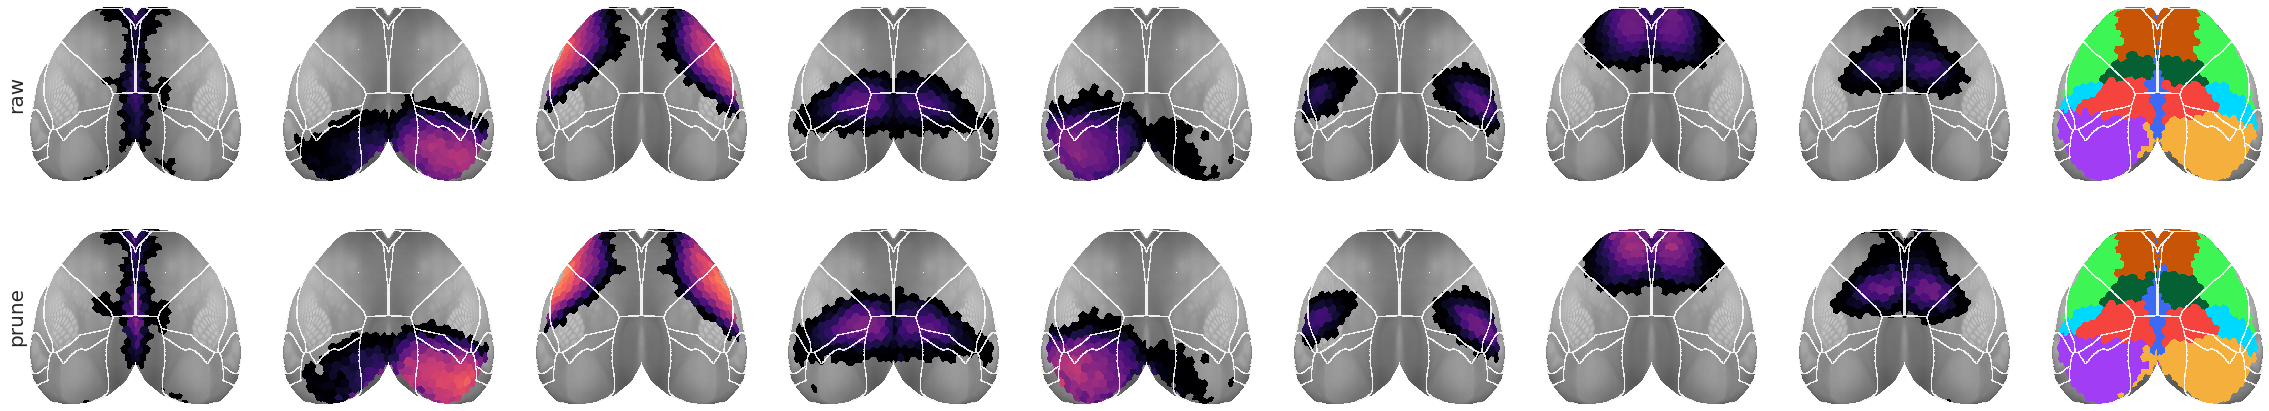

In [6]:
kws_show['figsize'] = (40, 7.5)
_ = bt.show(
    data={
        'raw': avg(bt_bo.run_pi),
        'prune': avg(bt_bo.pi_prune)},
    **kws_show,
)

### MG

In [7]:
thres = 0.372
bt_bo.run_pi, *_ = bt_bo._merge_vis(thres, bt_bo.run_pi)
bt_bo.pi_prune, *_ = bt_bo._merge_vis(thres, bt_bo.pi_prune)
bt_bo.num_k -= 1

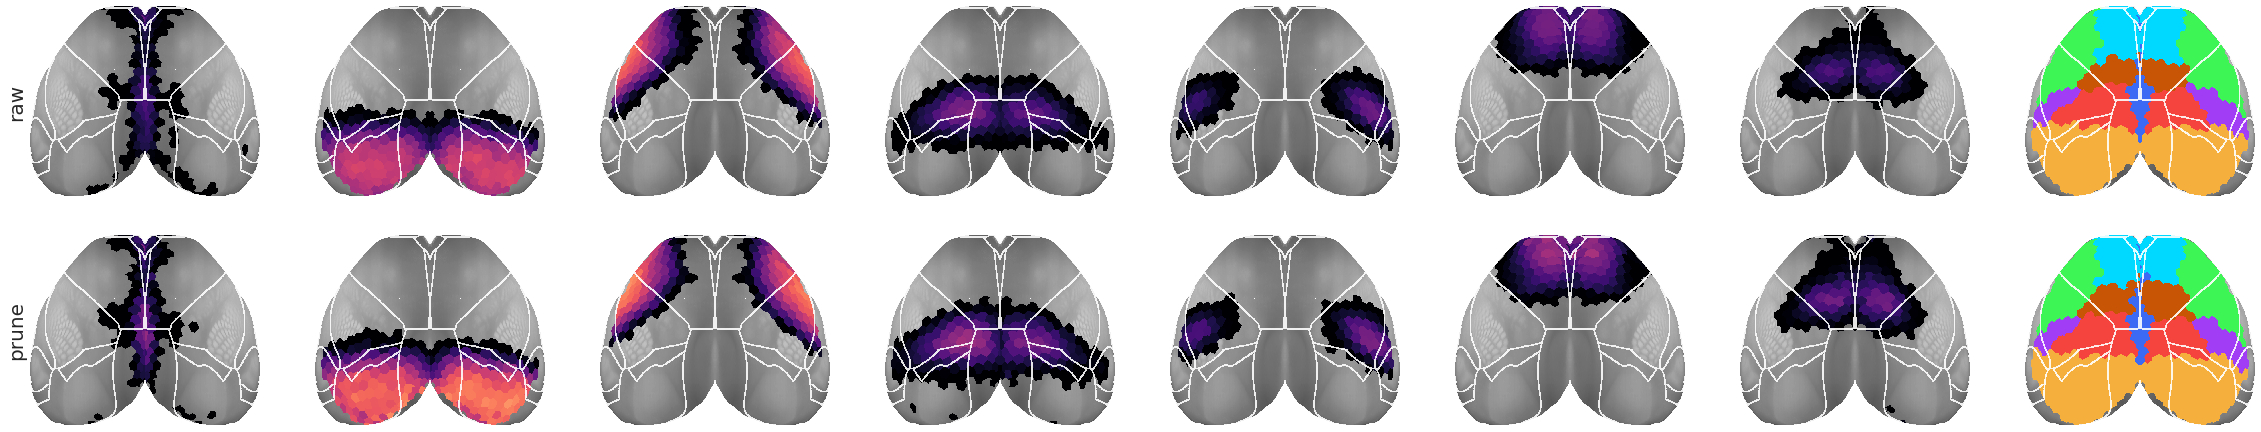

In [8]:
kws_show['figsize'] = (40, 7.7)
_ = bt.show(
    data={
        'raw': avg(bt_bo.run_pi),
        'prune': avg(bt_bo.pi_prune)},
    **kws_show,
)

### Sort

In [9]:
pi_dict = {
    mode: avg(o.run_pi) for
    mode, o in bt_dict.items()
}
pi_sorted, gmaps = sort_communities(
    pi_dict=pi_dict,
    label_keys={'bold': _BOLD, 'cas': _CAS, 'caf': _CAF},
    global_order=('infer', False),
    match_metric='correlation',
    bold_as_src=True,
)

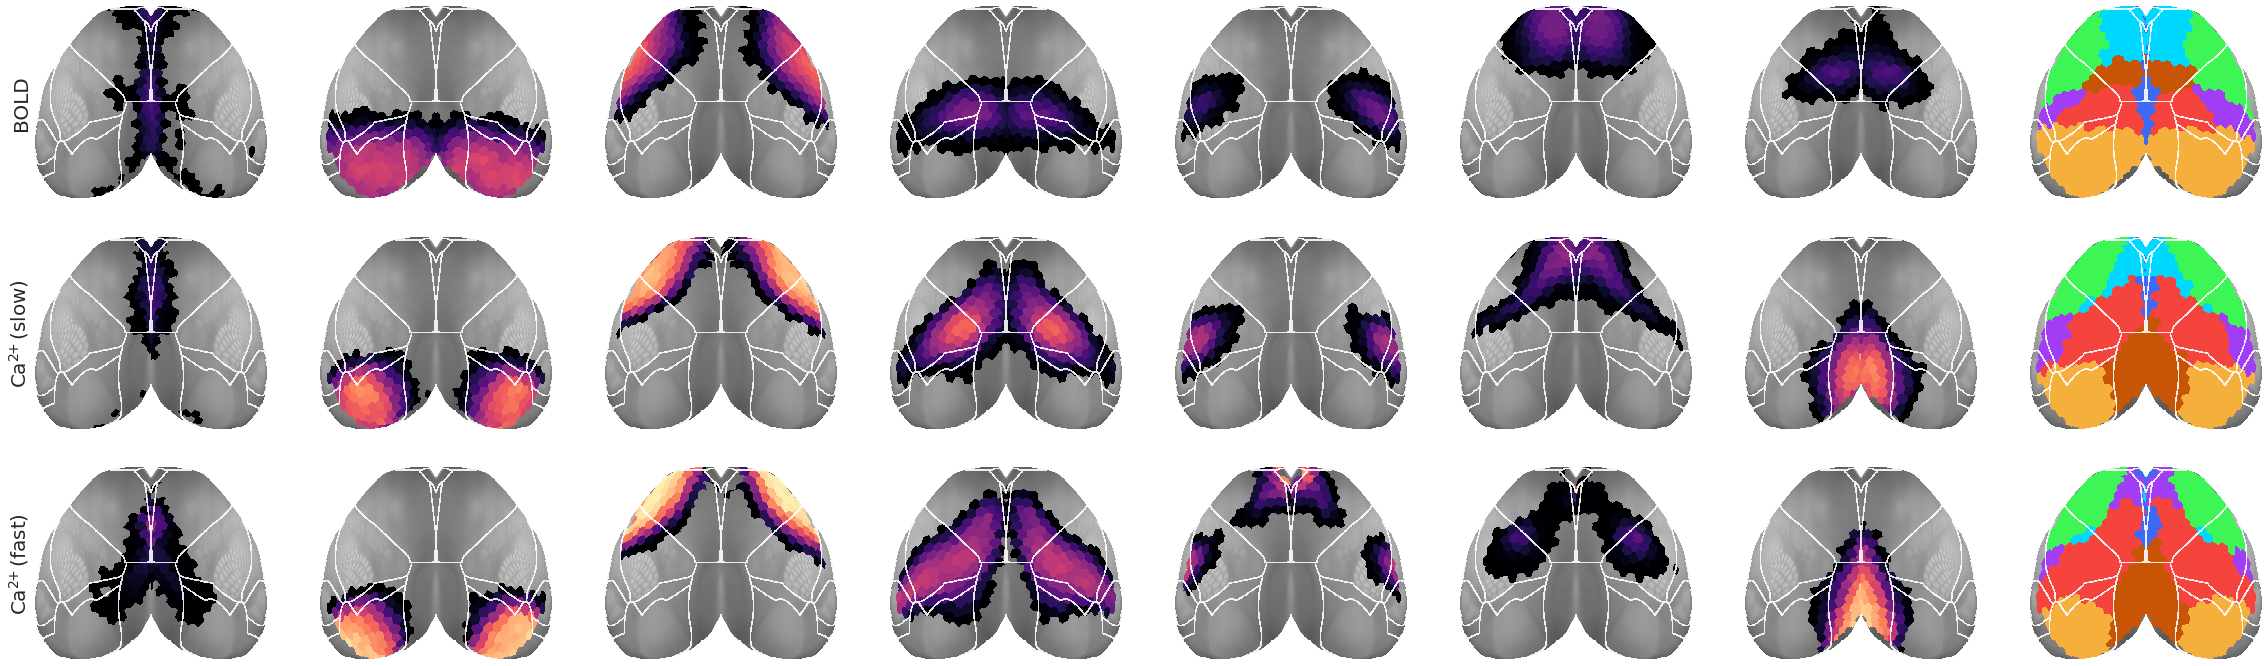

In [10]:
kws_show['figsize'] = (40, 12)
_ = bt.show(
    data=pi_sorted,
    **kws_show,
)

## Similarity

In [11]:
sim = {}
sim_overall = {}
for mode1, mode2 in itertools.combinations(pi_sorted, 2):
    x1 = pi_sorted[mode1]
    x2 = pi_sorted[mode2]
    good = np.logical_and(
        np.isnan(x1).sum(0) == 0,
        np.isnan(x2).sum(0) == 0,
    )
    sim[(mode1, mode2)] = dist2sim(sp_dist.cdist(
        XA=x1[:, good],
        XB=x2[:, good],
        metric='cosine',
    ))
    sim_overall[(mode1, mode2)] = dist2sim(sp_dist.cosine(
        u=x1[:, good].ravel(),
        v=x2[:, good].ravel(),
    ))

In [12]:
heatmap_kws = {
    'fmt': '.2f',
    'vmin': 0.5,
    'vmax': 1.0,
    'annot': True,
    'square': True,
    'annot_kws': {
        'fontsize': 13,
        'fontname': 'Loma'},
    'cbar_kws': {
        'shrink': 1.0,
        'aspect': 17,
        'pad': 0.08},
    'cmap': 'gist_heat',
}

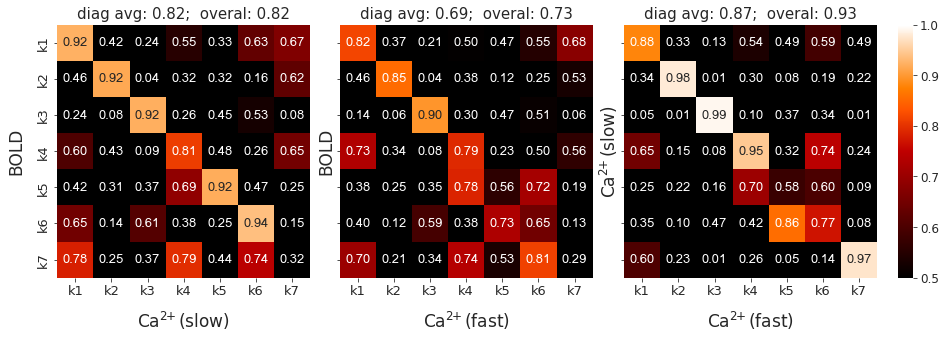

In [14]:
tick_labels = [f"k{k}" for k in range(1, num_k + 1)]
fig, axes = create_figure(1, 3, (13, 4.6), 'all', 'all', tight_layout=False, constrained_layout=True)

for i, ((lbl_1, lbl_2), x) in enumerate(sim.items()):
    ax = axes[i]
    sns.heatmap(
        data=x,
        cbar=True if
        i == 2 else False,
        **heatmap_kws,
        ax=ax,
    )
    ax.set_ylabel(lbl_1, fontsize=17, labelpad=12 if i == 0 else None)
    ax.set_xlabel(lbl_2, fontsize=17, labelpad=12)

    title = f"diag avg: {x.diagonal().mean():0.2f};  "
    title += f"overal: {sim_overall[(lbl_1, lbl_2)]:0.2f}"
    ax.set_title(title, fontsize=15)

    ax.set(
        xticklabels=tick_labels,
        yticklabels=tick_labels,
    )
    ax.tick_params(axis='both', labelsize=13)
    
    if i == 2:
        cax = plt.gcf().axes[-1]
        # cax.patch.set_linewidth(1.5)
        # cax.patch.set_edgecolor('k')
        cax.tick_params(labelsize=12)
        
plt.show()

### Similarity boot

In [23]:
data = []
for mode, o in bt_dict.items():
    x = bn.nanmean(o.run_pi, -3)
    gmap = gmaps.get(mode)
    if gmap:
        x = x[..., list(gmap.values()), :]
    data.append(np.expand_dims(x, -1))
data = np.concatenate(data, axis=-1)
data.shape

(10, 3, 4, 7, 542, 3)

In [61]:
%%time

boot = bootstrap(
    x=data,
    n_resamples=int(1e5),
    statistic=lambda a: avg(a, 3, 1),
    dims=3,
)

CPU times: user 6min 24s, sys: 3.71 s, total: 6min 28s
Wall time: 6min 28s


In [62]:
sim_b = collections.defaultdict(list)
sim_overall_b = collections.defaultdict(list)
for b in range(len(boot)):
    x = boot[b]
    for i, j in itertools.combinations(range(3), 2):
        lbl_1 = list(bt_dict)[i]
        lbl_2 = list(bt_dict)[j]
        x1 = x[..., i]
        x2 = x[..., j]
        good = np.logical_and(
            np.isnan(x1).sum(0) == 0,
            np.isnan(x2).sum(0) == 0,
        )
        
        s = dist2sim(sp_dist.cdist(
            XA=x1[:, good],
            XB=x2[:, good],
            metric='cosine',
        ))
        s = np.expand_dims(s, 0)
        sim_b[(lbl_1, lbl_2)].append(s)
        
        s = dist2sim(sp_dist.cosine(
            u=x1[:, good].ravel(),
            v=x2[:, good].ravel(),
        ))
        sim_overall_b[(lbl_1, lbl_2)].append(s)

sim_b = {k: np.concatenate(v) for k, v in sim_b.items()}
sim_overall_b = {k: np.array(v) for k, v in sim_overall_b.items()}

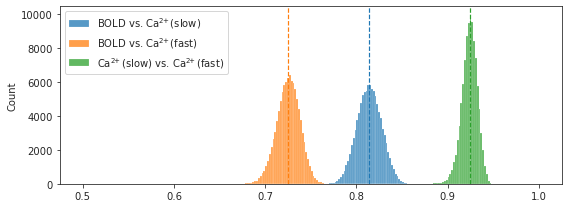

In [217]:
fig, ax = create_figure(1, 1, (8, 3))
for i, ((lbl_1, lbl_2), x) in enumerate(sim_overall_b.items()):
    sns.histplot(
        data=x,
        bins=np.linspace(0.5, 1, 251),
        label=f"{lbl_1} vs. {lbl_2}",
        color=f"C{i}",
        ax=ax
    )
    ax.axvline(x.mean(), color=f"C{i}", ls='--', lw=1.2)
ax.legend()
plt.show()

In [71]:
for k, v in sim_overall_b.items():
    se = np.nanstd(v, 0, ddof=1)
    print(k, se)

('BOLD', 'Ca$^{2\\!\\!+}$(slow)')
0.01342569844871674

('BOLD', 'Ca$^{2\\!\\!+}$(fast)')
0.012694070074752558

('Ca$^{2\\!\\!+}$(slow)', 'Ca$^{2\\!\\!+}$(fast)')
0.008481829385840465

In [72]:
se * get_tval()

0.019187231098326034

In [73]:
for k, v in sim_b.items():
    se = np.nanstd(v, 0, ddof=1)
    print(k, se.shape)

('BOLD', 'Ca$^{2\\!\\!+}$(slow)')
(7, 7)

('BOLD', 'Ca$^{2\\!\\!+}$(fast)')
(7, 7)

('Ca$^{2\\!\\!+}$(slow)', 'Ca$^{2\\!\\!+}$(fast)')
(7, 7)

<matplotlib.colorbar.Colorbar object at 0x7f3994baea90>

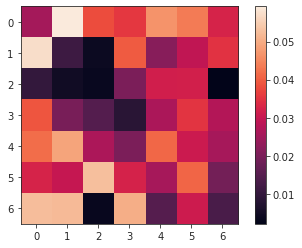

In [74]:
plt.imshow(se)
plt.colorbar()

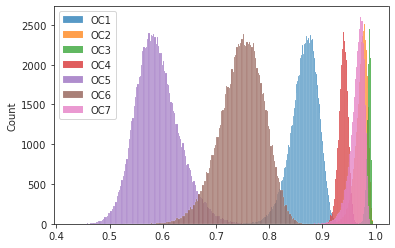

In [81]:
for i in range(num_k):
    sns.histplot(v[:, i, i], color=f'C{i}', label=f'OC{i+1}')
plt.legend()
plt.show()

### Perm test

In [192]:
data.shape

(10, 3, 4, 7, 542, 3)

In [193]:
good_runs = collections.defaultdict(list)
for ii, jj in itertools.combinations(range(3), 2):
    lbl_1 = list(bt_dict)[ii]
    lbl_2 = list(bt_dict)[jj]
    x1 = data[..., ii]
    x2 = data[..., jj]

    i, j, k = data.shape[:3]
    looper = itertools.product(
        range(i), range(j), range(k),
    )
    for i, j, k in looper:
        y1 = x1[i, j, k]
        y2 = x2[i, j, k]
        good = np.logical_and(
            np.isnan(y1).sum(0) == 0,
            np.isnan(y2).sum(0) == 0,
        )
        if good.sum():
            good_runs[(lbl_1, lbl_2)].append((i, j, k))
good_runs = {k: set(v) for k, v in good_runs.items()}
good_runs = set.intersection(*good_runs.values())
good_runs = sorted(good_runs)
len(good_runs)

108

In [221]:
data4perm = collections.defaultdict(list)
for ii, jj in itertools.combinations(range(3), 2):
    lbl_1 = list(bt_dict)[ii]
    lbl_2 = list(bt_dict)[jj]
    x1 = data[..., ii]
    x2 = data[..., jj]
    
    for i, j, k in good_runs:
        y1 = x1[i, j, k]
        y2 = x2[i, j, k]
        good = np.logical_and(
            np.isnan(y1).sum(0) == 0,
            np.isnan(y2).sum(0) == 0,
        )
        if not good.sum():
            continue
        s = dist2sim(sp_dist.cosine(
            u=y1[:, good].ravel(),
            v=y2[:, good].ravel(),
        ))
        data4perm[(lbl_1, lbl_2)].append(s)
data4perm = {k: np.array(v) for k, v in data4perm.items()}
{k: v.shape for k, v in data4perm.items()}

{
    ('BOLD', 'Ca$^{2\\!\\!+}$(slow)'): (108,),
    ('BOLD', 'Ca$^{2\\!\\!+}$(fast)'): (108,),
    ('Ca$^{2\\!\\!+}$(slow)', 'Ca$^{2\\!\\!+}$(fast)'): (108,)
}

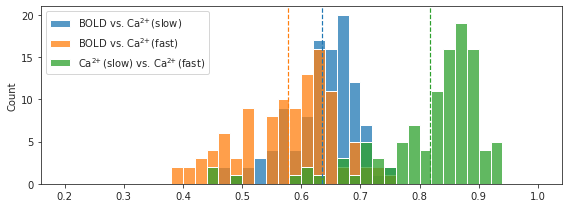

In [222]:
fig, ax = create_figure(1, 1, (8, 3))
for i, ((lbl_1, lbl_2), x) in enumerate(data4perm.items()):
    sns.histplot(
        data=x,
        bins=np.linspace(0.2, 1, 41),
        label=f"{lbl_1} vs. {lbl_2}",
        color=f"C{i}",
        ax=ax,
    )
    ax.axvline(x.mean(), color=f"C{i}", ls='--', lw=1.2)
ax.legend()
plt.show()

In [223]:
def statistic(a, b):
    return np.nanmean(a - b)

In [242]:
msg = ''
x = statistic(list(data4perm.values())[0], list(data4perm.values())[1])
msg += f"Blue \t -   Orange : \t {x:0.3f};\n"
x = statistic(list(data4perm.values())[0], list(data4perm.values())[2])
msg += f"Blue \t -   Green  : \t {x:0.3f};\n"
x = statistic(list(data4perm.values())[1], list(data4perm.values())[2])
msg += f"Orange \t -   Green  : \t {x:0.3f};\n"

print(msg)

Blue     -   Orange :    0.057;
Blue     -   Green  :    -0.182;
Orange   -   Green  :    -0.239;

( BOLD  /  Ca$^{2\!\!+}$(slow) ) vs. ( BOLD  /  Ca$^{2\!\!+}$(fast) )
pval = 2.000e-07;  statistic = 0.057;  pval = 0.000000200000

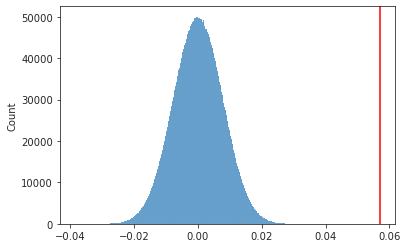

( BOLD  /  Ca$^{2\!\!+}$(slow) ) vs. ( Ca$^{2\!\!+}$(slow)  /  Ca$^{2\!\!+}$(fast) )
pval = 2.000e-07;  statistic = -0.182;  pval = 0.000000200000

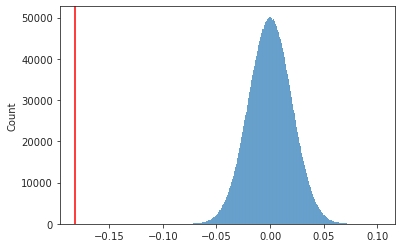

( BOLD  /  Ca$^{2\!\!+}$(fast) ) vs. ( Ca$^{2\!\!+}$(slow)  /  Ca$^{2\!\!+}$(fast) )
pval = 2.000e-07;  statistic = -0.239;  pval = 0.000000200000

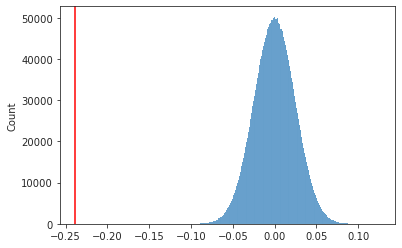

CPU times: user 3h 9min 49s, sys: 6.66 s, total: 3h 9min 56s
Wall time: 3h 9min 56s


In [224]:
%%time

for ii, jj in itertools.combinations(range(3), 2):
    cond_1, vals_1 = list(data4perm.items())[ii]
    cond_2, vals_2 = list(data4perm.items())[jj]

    test = sp_stats.permutation_test(
        data=(vals_1, vals_2),
        statistic=statistic,
        permutation_type='samples',
        alternative='two-sided',
        n_resamples=int(1e7),
        random_state=42,
        batch=5,
    )
    msg = f"( {cond_1[0]}  /  {cond_1[1]} ) vs. ( {cond_2[0]}  /  {cond_2[1]} )\n"
    msg += f"pval = {test.pvalue:1.3e};  statistic = {test.statistic:.3f};  pval = {test.pvalue:0.12f}\n"
    print(msg)
    
    sns.histplot(test.null_distribution)
    plt.axvline(test.statistic, color='r')
    plt.show()

In [229]:
reject, pvals, *_ = multipletests([2e-7] * 3, method='fdr_bh')
reject.sum()

3

## Make column plots

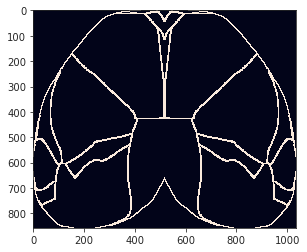

In [271]:
contour = bt.get_contour(0.2, True)
plt.imshow(contour);

In [272]:
mask_thres = 1 / num_k
vmin = 0.2
vmax = 1.0
cbar = False
cmap = 'magma'
interp = 'antialiased'

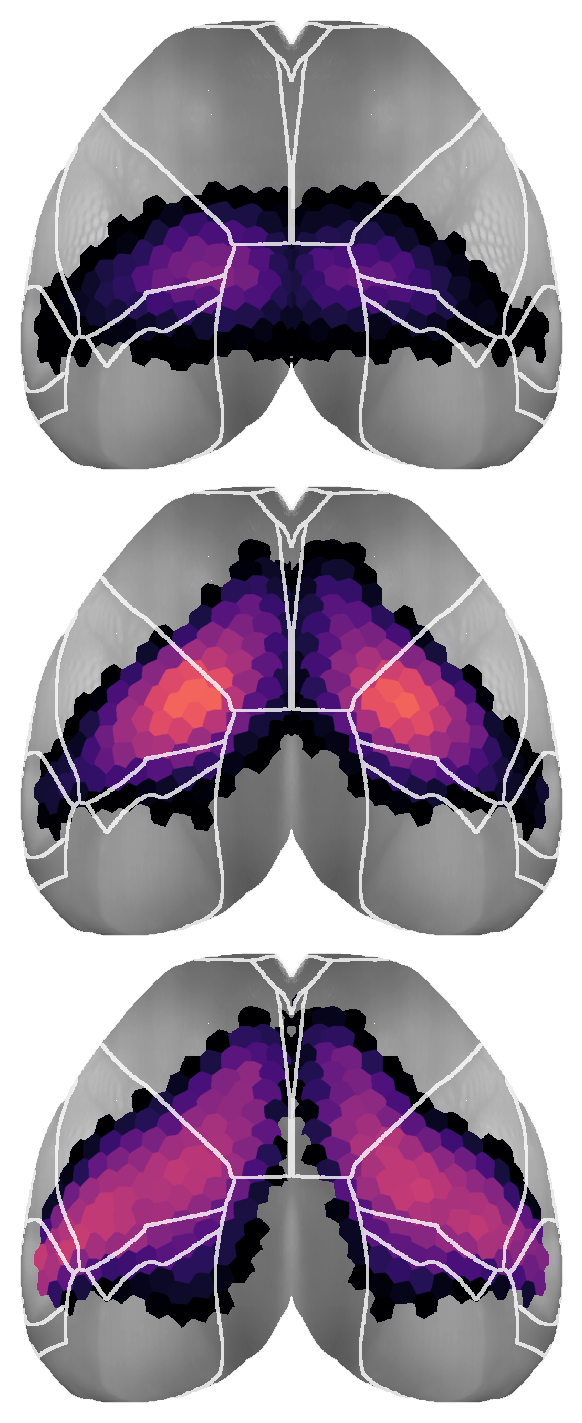

In [274]:
fig, axes = create_figure(
    nrows=3,
    ncols=1,
    figsize=(3, 7),
    sharex='all',
    sharey='all',
    tight_layout=False,
    constrained_layout=True,
    dpi=200,
)
i = 3
for j, (mode, pi) in enumerate(pi_sorted.items()):
    x = pi[i]
    x[x < mask_thres] = np.nan
    
    ax = axes[j]
    ax = ctx2ax(
        x=x,
        ax=ax,
        base=bt,
        vmin=vmin,
        vmax=vmax,
        cmap=cmap,
        cbar=cbar,
        interp=interp,
        contour=contour,
    )
remove_ticks(axes)

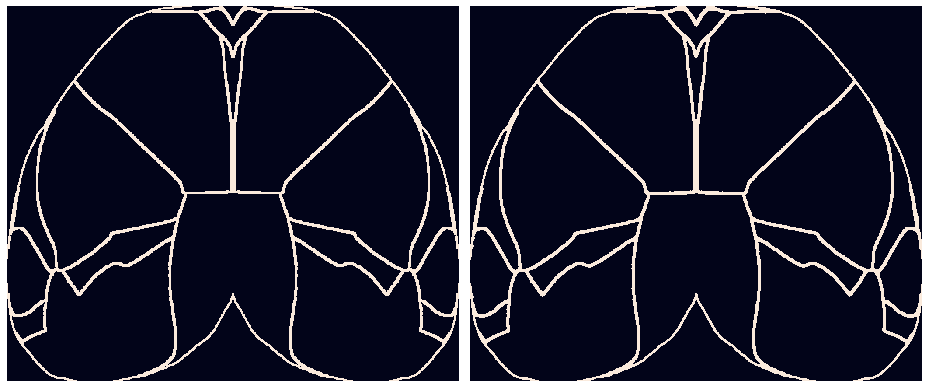

In [330]:
fig, axes = create_figure(1, 2, (13, 6))
axes[0].imshow(contour)

x = sp_img.median_filter(contour, 6)
# x = x > 0
axes[1].imshow(x)

remove_ticks(axes)

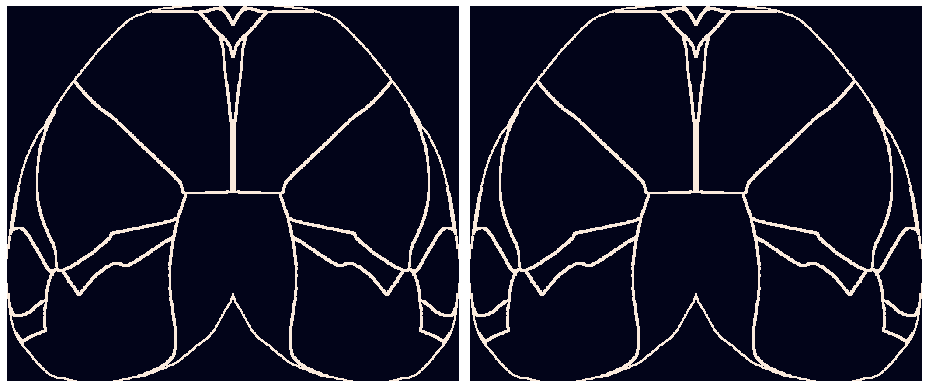

In [347]:
fig, axes = create_figure(1, 2, (13, 6))
axes[0].imshow(contour)

x = sp_img.gaussian_filter(contour, 0.1)
# x = x > 0
axes[1].imshow(x)

remove_ticks(axes)

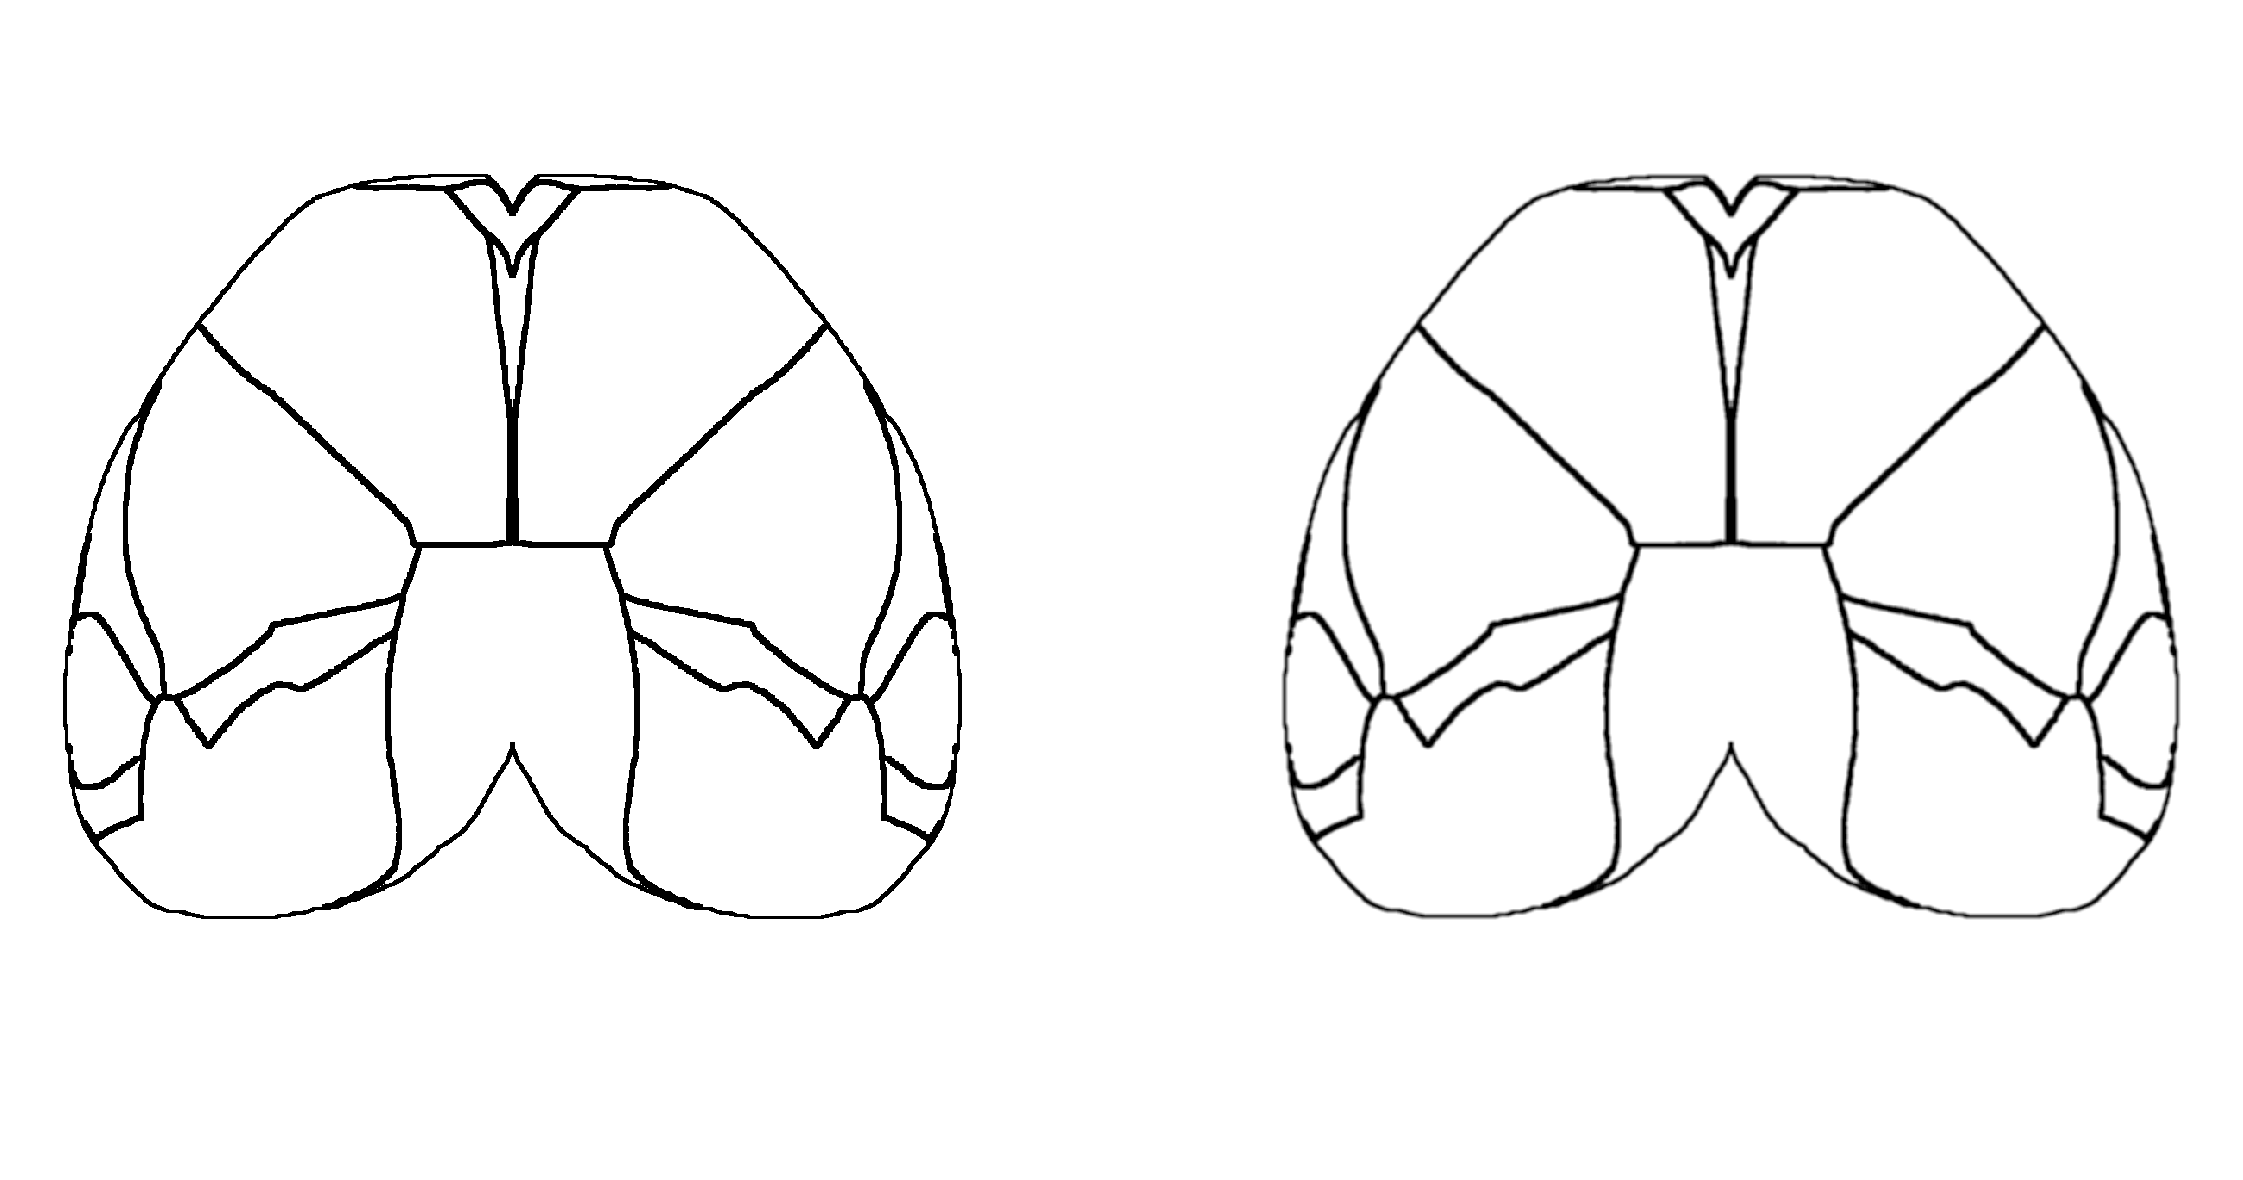

In [444]:
fig, axes = create_figure(1, 2, (13, 6), dpi=200)
axes[0].imshow(contour, cmap='Greys')

d = 5
x = sp_sig.convolve(contour, np.ones((d, d)))
# x = x > 0.01
axes[1].imshow(x, cmap='Greys')

remove_ticks(axes)

In [398]:
self = bt
if self.topview is None:
    _ = self.load_top_flat()
if self.affil is None:
    _ = self.node_affiliations()
obj = self.affil['obj_top'].copy()

width = 0.2
coarse = True

if coarse:
    subtree, _ = self.mice.al.get_subtree(315, 2, False)
    children = collections.defaultdict(list)
    nodes = [n.identifier for n in subtree.children(315)]
    nodes += [self.mice.al.get('SSp')['id']]
    for node in nodes:
        for child in subtree.children(node):
            children[node].append(child.identifier)

    for node, child_list in children.items():
        obj[np.isin(obj, child_list)] = node
contour = get_contour(obj, 0.125, width)

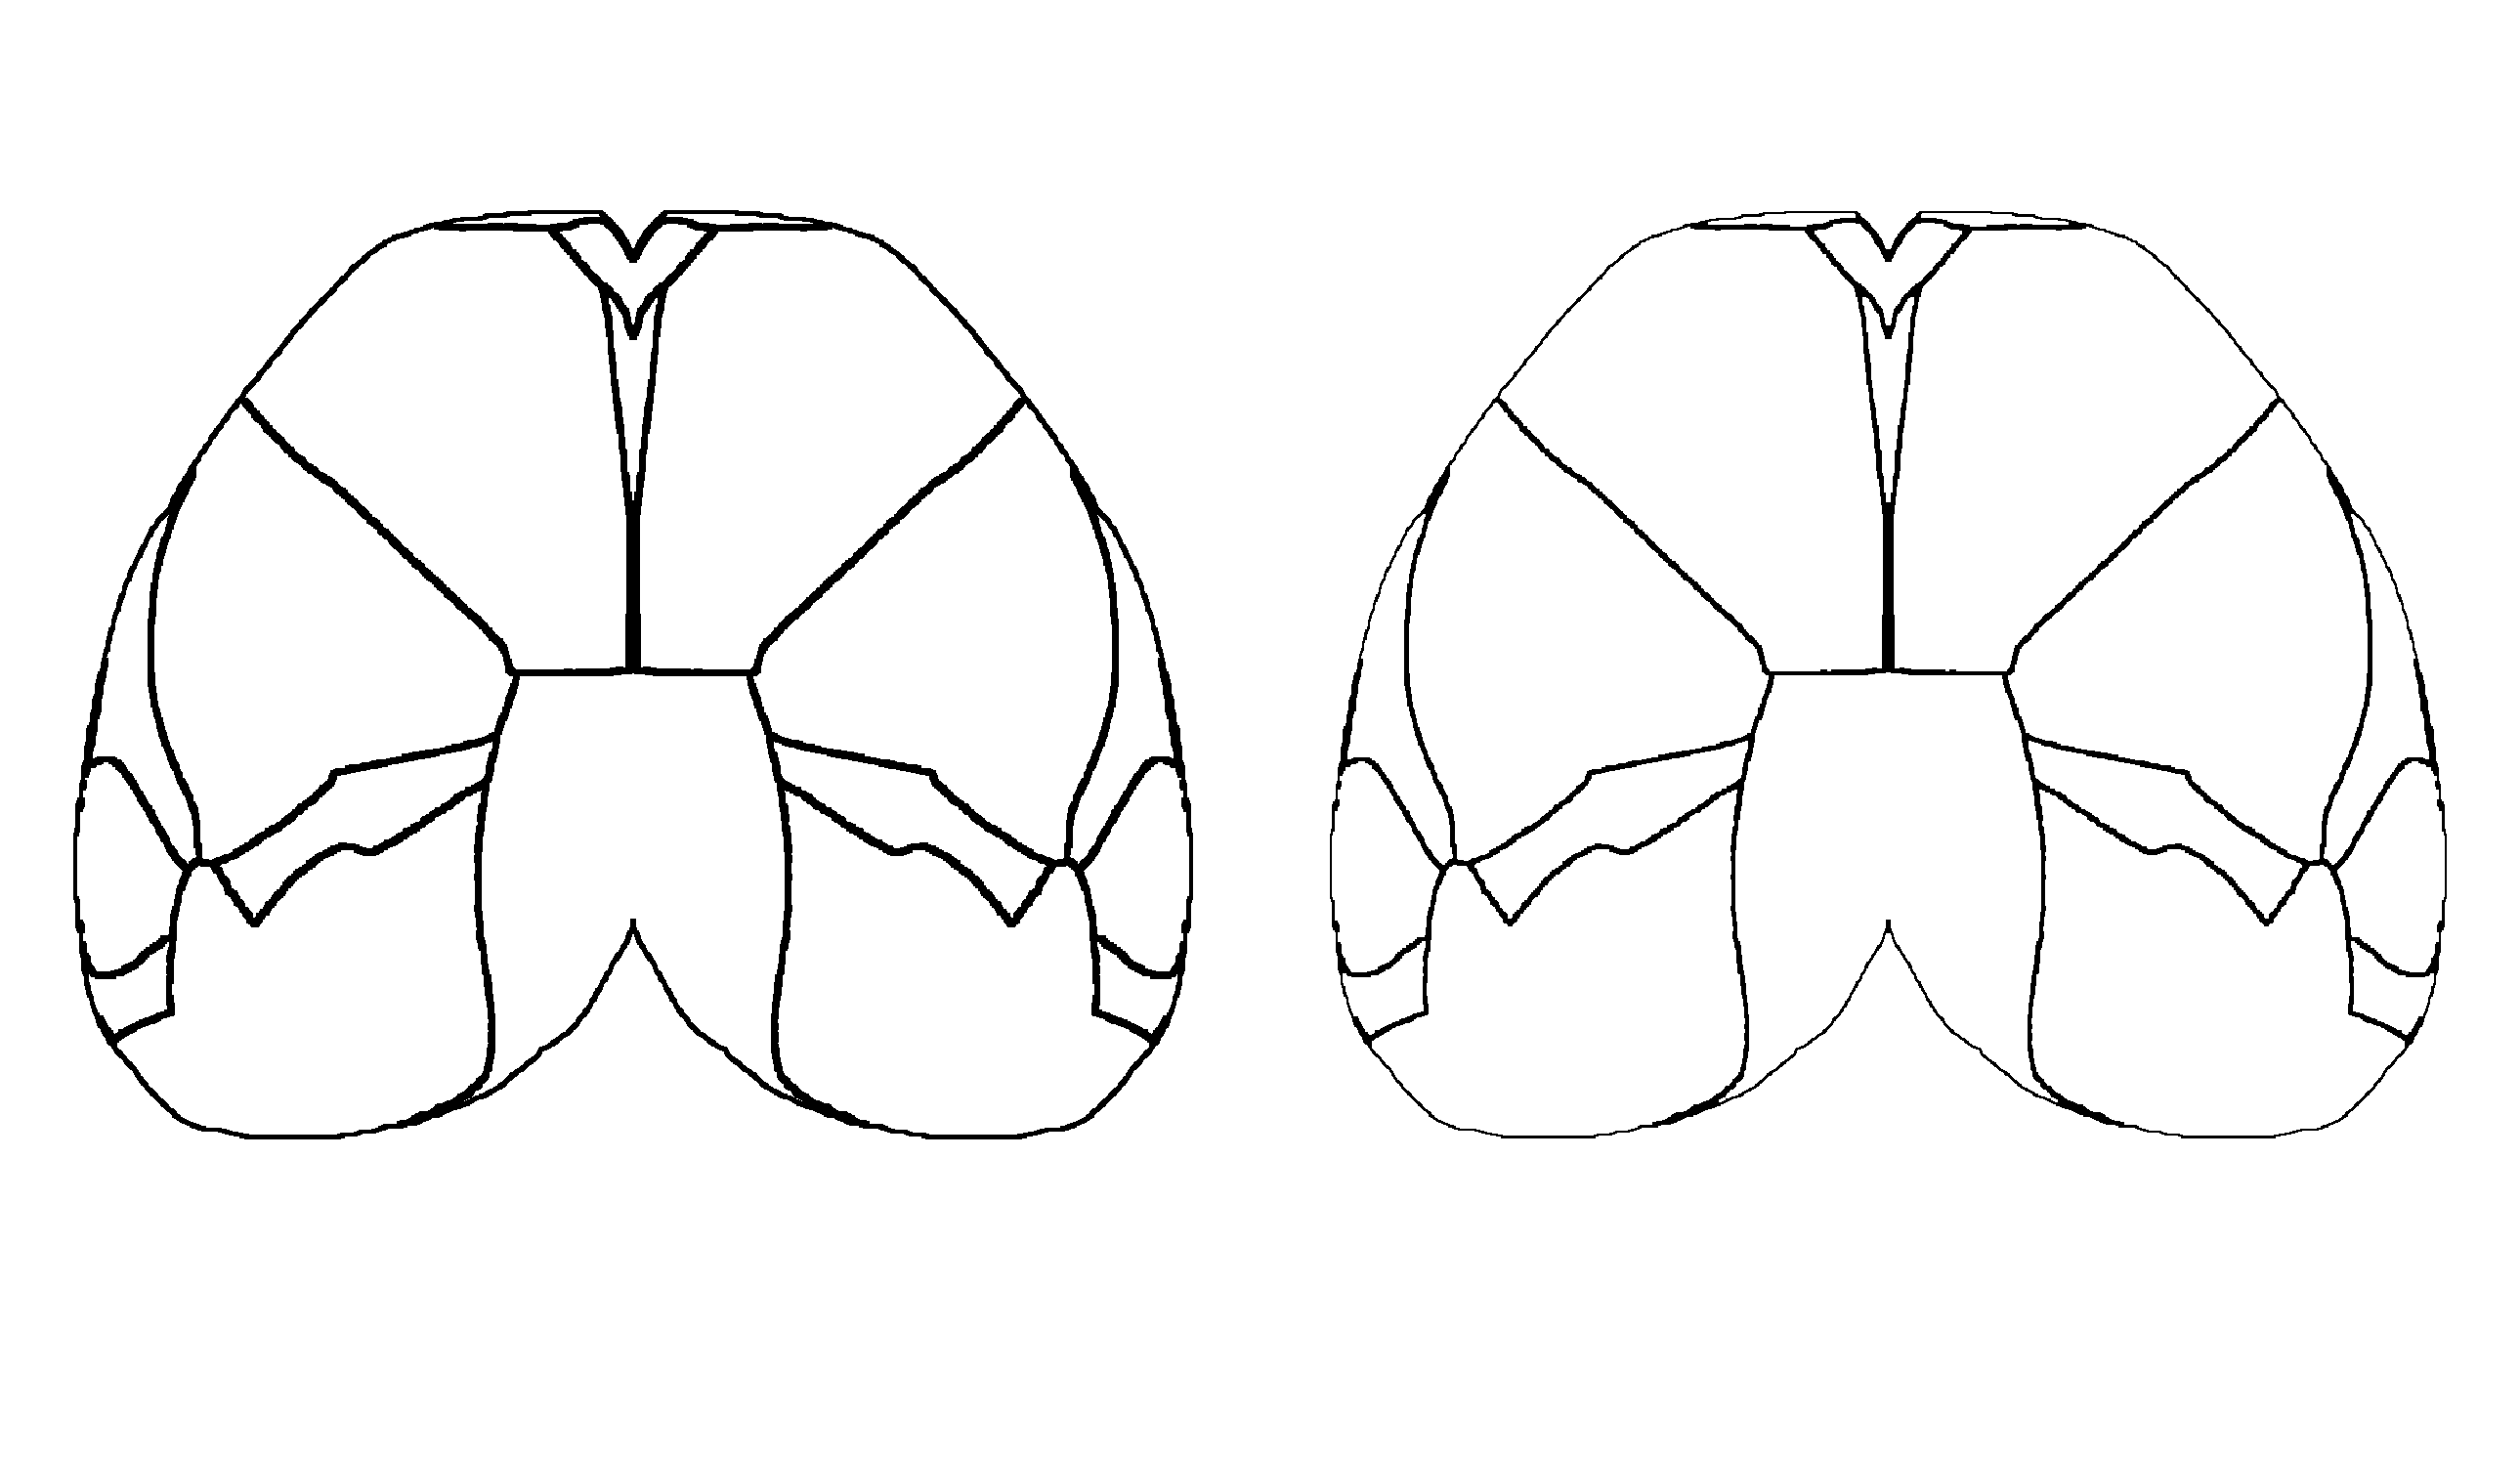

In [414]:
fig, axes = create_figure(1, 2, (13, 9), dpi=200)
axes[0].imshow(contour, cmap='Greys')

x = sp_img.gaussian_filter(contour, 0.2)
# x = x > 0.01
axes[1].imshow(x, cmap='Greys')

remove_ticks(axes)